# Core Imports

In [1]:
# Custom Imports
from polysaccharide import general
from polysaccharide.extratypes import ResidueSmarts

from polysaccharide.molutils import reactions
from polysaccharide.molutils.rdmol.rdtypes import *
from polysaccharide.molutils.rdmol import rdcompare, rdconvert, rdkdraw, rdcompare, rdprops, rdbond, rdlabels

from polysaccharide.polymer import monomer
from polysaccharide.polymer.monomer import MonomerInfo

# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
RAW_DATA_PATH = Path('raw_monomer_data')
RXN_FILES_PATH = Path('rxn_smarts')

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Wa

# Inspecting NREL Urethanes

## Loading and inspecting raw data

In [4]:
p = RAW_DATA_PATH / 'nipu_urethanes.xlsx'
raw_table = pd.read_excel(p) # load from .xlsx file
raw_table['Monomers'] = raw_table['Monomers'].apply(literal_eval) # convert string of tuples into proper tuples

nipus     = raw_table[raw_table['Chemistry'] == 'NIPU'    ]
urethanes = raw_table[raw_table['Chemistry'] == 'urethane']

nipus_mono     = nipus['Monomers'].reset_index(drop=True) # extract monomers and renumber subset in-order
urethanes_mono = urethanes['Monomers'].reset_index(drop=True) # extract monomers and renumber subset in-order

In [2]:
rdkdraw.set_rdkdraw_size(300, 3/2)
# targ_mono = nipus_mono
targ_mono = {}

for i, monos in targ_mono.items():
    try:
        mono1, mono2 = monos
        display(Chem.MolFromSmiles(mono1))
        
        print('='*50)
    except ValueError:
        print(f'Row {i} failed')

## Classify each monomer pair by respective reactive functional group

In [5]:
with (RXN_FILES_PATH / 'fn_group_smarts.json').open('r') as fn_group_file:
    fn_group_SMARTS = json.load(fn_group_file)
    fn_groups = {
        group_name : Chem.MolFromSmarts(SMARTS)
            for group_name, SMARTS in fn_group_SMARTS.items()
    }

reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}

all_results = []
digroup_only_results = []
for i, (chemistry, monomer_pair) in raw_table.iterrows():
    monomer_entry = {
        'Chemistry' : chemistry
    }

    too_many_sites = False
    for SMILES in monomer_pair:
        rdmol = Chem.MolFromSmiles(SMILES)
        rdmol = Chem.AddHs(rdmol)

        for group_name, fn_group in fn_groups.items():
            matches = rdmol.GetSubstructMatches(fn_group)
            if matches and (group_name in reaction_pairs[chemistry]):
                monomer_entry[group_name] = Chem.MolToSmarts(rdmol)
            too_many_sites |= (len(matches) > 2) # OR with previous result; single true will make result true
        
    all_results.append(monomer_entry)
    if not too_many_sites:        
        digroup_only_results.append(monomer_entry)

all_table = pd.DataFrame.from_records(all_results)
digroup_table = pd.DataFrame.from_records(digroup_only_results)

## Testing reaction replacement rules

In [6]:
with (RXN_FILES_PATH / 'rxn_smarts.json').open('r') as rxn_file:
    rxn_smarts = json.load(rxn_file)
    rxns = {
        chemistry : reactions.AnnotatedReaction.from_smarts(rxn_SMARTS)
            for chemistry, rxn_SMARTS in rxn_smarts.items()
    }

In [26]:
rxn_r_map4 = """$RXN

      Mrv1902  070320191331

  2  1
$MOL

  Mrv1902 07031913312D          

  3  2  0  0  0  0            999 V2000
   -4.5670   -0.2063    0.0000 C   0  0  0  0  0  0  0  0  0  2  0  0
   -5.2815    0.2062    0.0000 O   0  0  0  0  0  0  0  0  0  1  0  0
   -3.8525    0.2063    0.0000 O   0  0  0  2  0  0  0  0  0  0  0  0
  1  2  2  0  0  0  0
  1  3  1  0  0  0  0
M  MRV SMA   3 [#8H1]
M  END
$MOL

  Mrv1902 07031913312D          

  2  1  0  0  0  0            999 V2000
   -1.1418    0.0687    0.0000 N   0  0  0  0  0  0  0  0  0  3  0  0
   -1.9668    0.0687    0.0000 R   0  0  0  0  0  0  0  0  0  4  0  0
  1  2  1  0  0  0  0
M  END
$MOL

  Mrv1902 07031913312D          

  4  3  0  0  0  0            999 V2000
    4.4565   -0.3572    0.0000 C   0  0  0  0  0  0  0  0  0  2  0  0
    5.2815   -0.3572    0.0000 O   0  0  0  0  0  0  0  0  0  1  0  0
    4.0439    0.3572    0.0000 N   0  0  0  0  0  0  0  0  0  3  0  0
    3.2190    0.3572    0.0000 R   0  0  0  0  0  0  0  0  0  4  0  0
  1  2  2  0  0  0  0
  1  3  1  0  0  0  0
  3  4  1  0  0  0  0
M  END
"""

rxn = rdChemReactions.ReactionFromRxnBlock(rxn_r_map4)

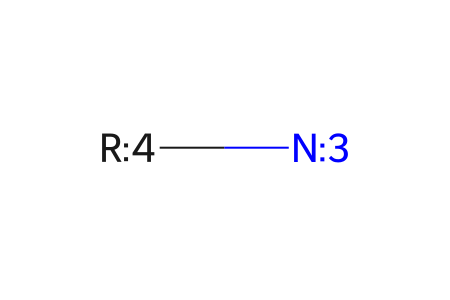

'[#7:3]-[*:4]'

In [27]:
mol = rxn.GetReactantTemplate(1)
display(mol)
Chem.MolToSmarts(mol)

In [28]:
atom = mol.GetAtomWithIdx(1)

atom.GetSymbol(), atom.GetAtomicNum()

('R', 0)

In [30]:
dir(atom.GetPDBResidueInfo)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [12]:
rxn = rxns['urethane']

rdChemReactions.ReactionToRxnBlock(rxn)

'$RXN\n\n      RDKit\n\n  2  1\n$MOL\n\n     RDKit          2D\n\n  4  3  0  0  0  0  0  0  0  0999 V2000\n    3.8971    0.7500    0.0000 O   0  0  0  0  0  0  0  0  0  1  0  0\n    2.5981   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  2  0  0\n    1.2990    0.7500    0.0000 N   0  0  0  0  0  0  0  0  0  3  0  0\n    0.0000    0.0000    0.0000 *   0  0  0  0  0  0  0  0  0  4  0  0\n  1  2  2  0\n  2  3  2  0\n  3  4  1  0\nV    4 [*:4]\nM  END\n$MOL\n\n     RDKit          2D\n\n  3  2  0  0  0  0  0  0  0  0999 V2000\n    1.2990    0.7500    0.0000 O   0  0  0  0  0  0  0  0  0  5  0  0\n    2.5981   -0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  6  0  0\n    0.0000    0.0000    0.0000 *   0  0  0  0  0  0  0  0  0  7  0  0\n  1  2  1  0\n  1  3  1  0\nV    3 [*:7]\nM  END\n$MOL\n\n     RDKit          2D\n\n  7  6  0  0  0  0  0  0  0  0999 V2000\n    3.8971    0.7500    0.0000 O   0  0  0  0  0  0  0  0  0  1  0  0\n    2.5981   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0 

In [21]:
block = Chem.MolToMolBlock(rxn.GetReactantTemplate(0))
block = block.replace('*', 'ALA')

print(block)


     RDKit          2D

  4  3  0  0  0  0  0  0  0  0999 V2000
    3.8971    0.7500    0.0000 O   0  0  0  0  0  0  0  0  0  1  0  0
    2.5981   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  2  0  0
    1.2990    0.7500    0.0000 N   0  0  0  0  0  0  0  0  0  3  0  0
    0.0000    0.0000    0.0000 ALA   0  0  0  0  0  0  0  0  0  4  0  0
  1  2  2  0
  2  3  2  0
  3  4  1  0
V    4 [ALA:4]
M  END



In [22]:
Chem.MolFromMolBlock(block)

[17:32:49] 

****
Post-condition Violation
Element 'ALA' not found
Violation occurred on line 93 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/PeriodicTable.h
Failed Expression: anum > -1
****

[17:32:49] Element 'ALA' not found


In [ ]:
# for j, sample in digroup_table.tail(2).iterrows():
# for j, sample in digroup_table.head(5).iterrows():

rdkdraw.set_rdkdraw_size(400, 3/2)
for sample in (digroup_table.iloc[2], digroup_table.iloc[-2]):
    # look up reactive groups and pathway by chemistry
    chemistry = sample['Chemistry']
    rxn_grp_names = reaction_pairs[chemistry]
    rxn = rxns[chemistry]

    # read reactant monomers from digroup_table
    reactants = []
    for i, group_name in enumerate(rxn_grp_names):
        reactant = Chem.MolFromSmarts(sample[group_name])
        for atom in reactant.GetAtoms():
            atom.SetProp('reactant_group', group_name)
        
        reactants.append(reactant)
    mono_info = MonomerInfo()

    # first round of polymerization (initiation)
    reactor_1 = reactions.PolymerizationReactor(rxn, reactants=reactants)
    reactor_1.react()
    display(reactor_1.polymerized_fragments(separate=False))

    mono_info.monomers[f'{"_".join(rxn_grp_names)}_DIMER'] = Chem.MolToSmarts(rdlabels.clear_atom_map_nums(reactor_1.product, in_place=False))
    for assoc_group_name, rdfragment in zip(rxn_grp_names, reactor_1.polymerized_fragments(separate=True)):
        rdlabels.clear_atom_isotopes(rdfragment, in_place=True)
        mono_info.monomers[f'{assoc_group_name}_TERM'] = Chem.MolToSmarts(rdfragment)

    # second round of polymerization (propagation)
    reactor_2 = reactions.PolymerizationReactor(rxn, reactor_1.polymerized_fragments(separate=True))
    reactor_2.react()
    display(reactor_2.polymerized_fragments(separate=False))

    for assoc_group_name, rdfragment in zip(rxn_grp_names, reactor_2.polymerized_fragments(separate=True)):
        rdlabels.clear_atom_isotopes(rdfragment, in_place=True)
        mono_info.monomers[f'{assoc_group_name}_MID'] = Chem.MolToSmarts(rdfragment)

    # add serial map numbers to monomer fragment SMARTS
    for monomer_tag, smarts in mono_info.monomers.items():
        monomer = Chem.MolFromSmarts(smarts)
        rdlabels.assign_ordered_atom_map_nums(monomer, in_place=True)
        mono_info.monomers[monomer_tag] = Chem.MolToSmarts(monomer)

mono_info